In [1]:
# Import necessary libraries
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, InputLayer, ReLU

%matplotlib inline



In [2]:
# Initialize a sequential model
model = Sequential(name="Receptive_field")

# First conv layer
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))

# Second conv layer
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# First max pooling layer
model.add(MaxPooling2D((2, 2)))

# Third conv layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Fourth conv layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Second max pooling layer
model.add(MaxPooling2D((2, 2)))

# Fifth conv layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Sixth conv layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Third max pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected dense layer
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))

# Fully connected dense layer
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compiling the model
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
model.load_weights("receptive_field_weights.h5")

# GETTING THE ACTIVATIONS

In [4]:
# Function to load the images given the file path
def load_image(img_path):

    img = image.load_img(img_path, target_size=(32, 32))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor = preprocess_input(img_tensor)               # imshow expects values in the range [0, 1]

    return img_tensor

In [5]:
path = "cifar/"
dirs = os.listdir(path)
layer_num = 7
activation_num=5

# Activation model
activation_model = Model(inputs=model.inputs, outputs=model.layers[7].output)


acts = []


for i in range(0,50):
  # Get path of images
  file_path = os.path.join(path, dirs[i])

  # Call the load_image function defined above to get the images
  img_path = load_image(file_path)

  # Get the model layer outputs
  last = activation_model(img_path)

  # Get the feature maps
  feature_map = activation_model.predict(img_path, verbose=0)

  # Get the output of the selected activation map
  select_act = feature_map[0,:,:,activation_num]

  # Save the selected activation to a list
  acts.append(select_act.flatten())
  

In [6]:
# Dictionary of pixel wise best image activation

# Define a dictionary to hold the pixel-wise image that activates it the most
best_img = {}

# Loop over the entire pixel space of the selected activation
for p in range(0,len(acts[0])):
    for i in range(0,len(acts)):
        if p not in best_img.keys():
            best_img[p] = i+1
        elif acts[best_img[p]][p] < acts[i][p]:
            best_img[p] = i+1


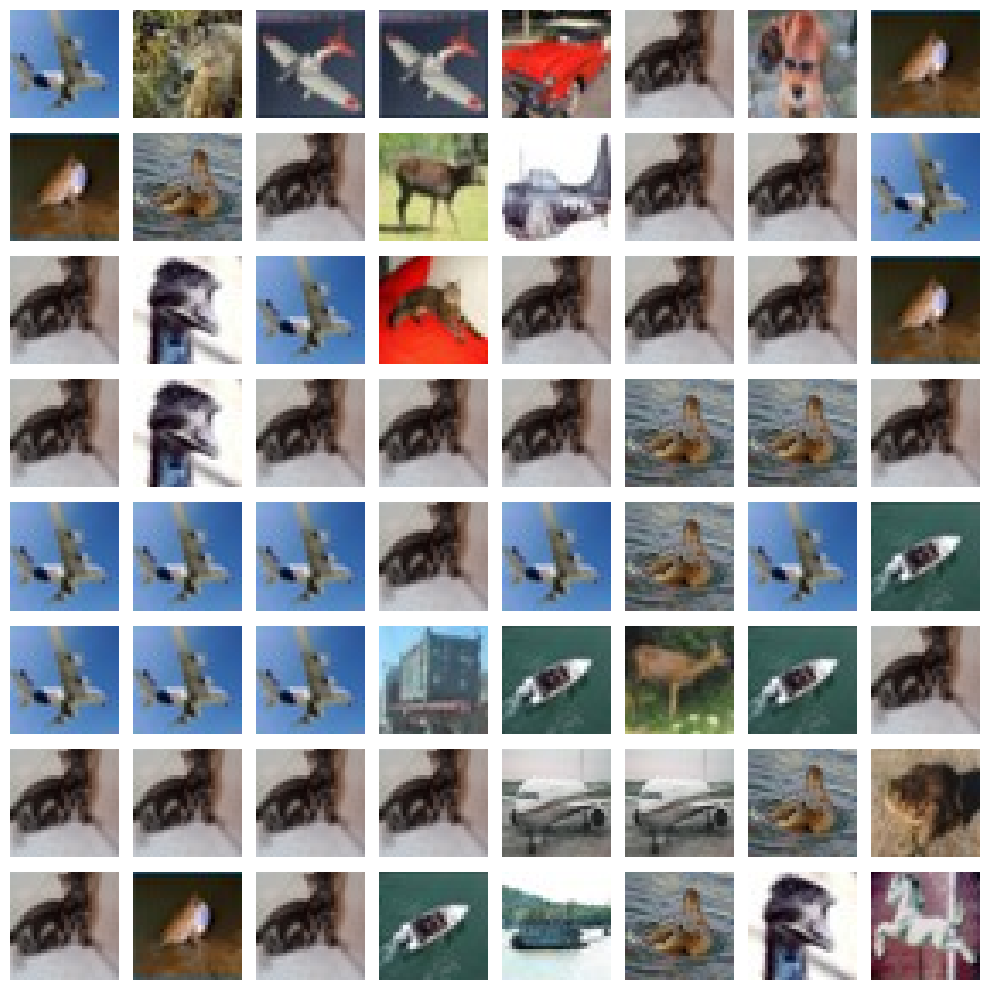

In [7]:
# Code to plot the receptive fields associated with each pixel

# print("Layer number: "+str(layer_num))
# print("Receptive field size: ", int(np.array(com[layer_num])[3]))

fig, ax = plt.subplots(model.layers[layer_num].output_shape[1], model.layers[layer_num].output_shape[2], figsize = (10,10))
counter = 0
# Loop over the possible pixel values of the feature map to plot the receptive fiels
for i in range(8):
  for j in range(8):

    # Denormalize the pixel values
    img_path = path+"img"+str(best_img[counter])+".jpg"
    ax[i][j].imshow((load_image(img_path).squeeze()/2)+0.5)
    ax[i][j].axis('off')
    counter+=1


plt.tight_layout()


## Methods of Backpropagation:
![](https://glassboxmedicine.files.wordpress.com/2019/10/figure1springenberg.png)

In [8]:
# Using the custom gradient decorater to perform backpropagation
# Write a custom ReLU function
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

# Switching the activation layers to the one defined above
conv_layers_index = [1,2,4,5,7,8]
for index in conv_layers_index:
  activation_model.layers[index].activation = guidedRelu


In [9]:
# Helper function that takes the gradients and 
# transforms them into values that can we plotted using matplotlib
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Visualizing first (top left) pixel

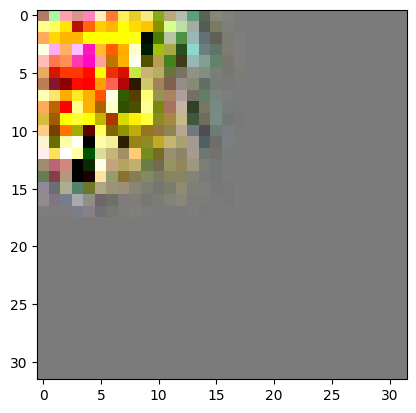

In [10]:
num_act = activation_num
counter = 0
img_path = path+"img"+str(best_img[counter])+".jpg"
preprocessed_input = load_image(img_path)
with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    feature_map = activation_model(inputs)[0]
    feature_map = feature_map[:,:,num_act]
    pixel = feature_map[counter//8,counter%8]
gg = tape.gradient(pixel,inputs)[0]
plt.imshow(np.flip(deprocess_image(np.array(gg)),-1))

## Visualizing 5th pixel

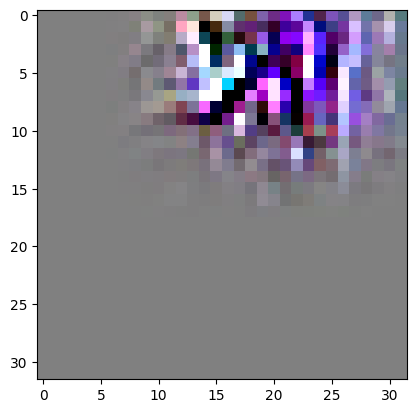

In [11]:
counter = 5
img_path = path+"img"+str(best_img[counter])+".jpg"
preprocessed_input = load_image(img_path)
with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    feature_map = activation_model(inputs)[0]
    feature_map = feature_map[:,:,num_act]
    pixel = feature_map[counter//8,counter%8]
gg = tape.gradient(pixel,inputs)[0]
plt.imshow(np.flip(deprocess_image(np.array(gg)),-1))

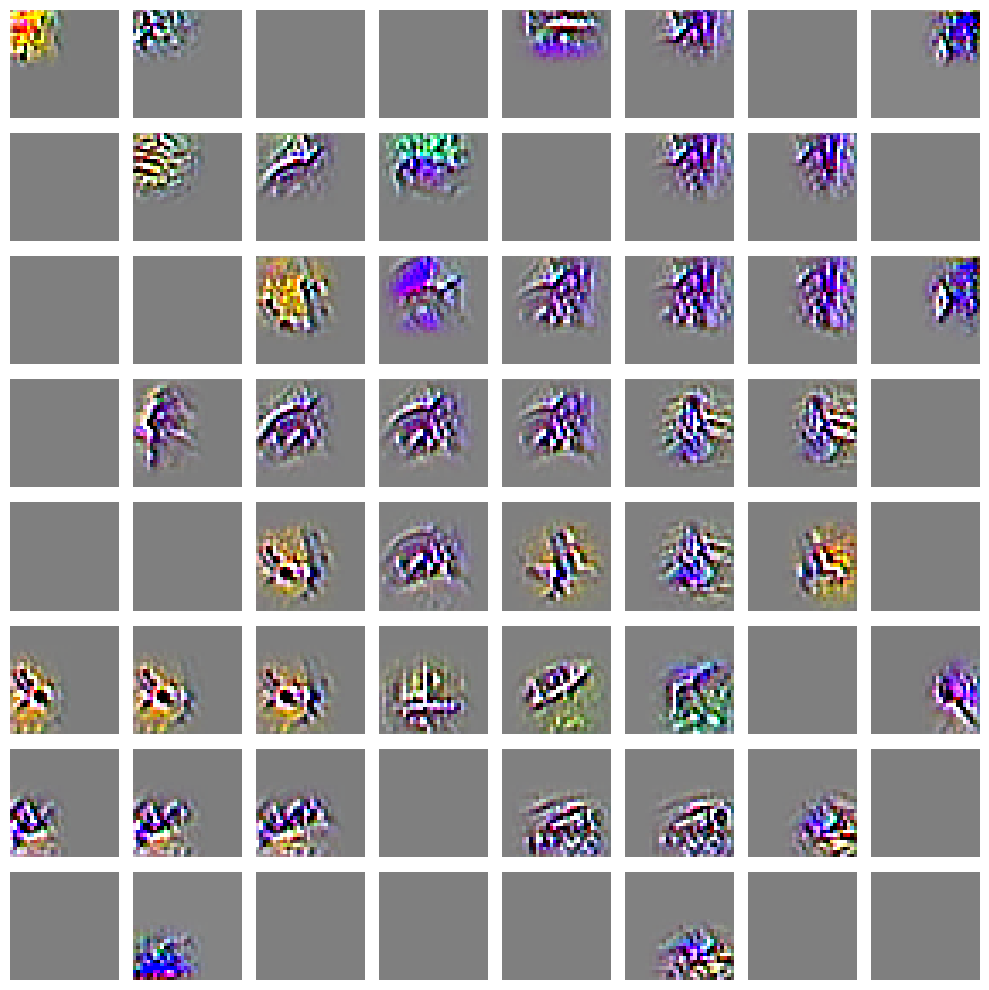

In [12]:
fig, ax = plt.subplots(model.layers[layer_num].output_shape[1], model.layers[layer_num].output_shape[2], figsize = (10,10))
counter = 0
# Loop over the possible pixel values of the feature map to plot the receptive fiels
for i in range(8):
  for j in range(8):

    # Denormalize the pixel values
    img_path = path+"img"+str(best_img[counter])+".jpg"
    preprocessed_input = load_image(img_path)
    with tf.GradientTape() as tape:
        inputs = tf.cast(preprocessed_input, tf.float32)
        tape.watch(inputs)
        feature_map = activation_model(inputs)[0]
        feature_map = feature_map[:,:,num_act]
        pixel = feature_map[counter//8,counter%8]
    gg = tape.gradient(pixel,inputs)[0]
    
    ax[i][j].imshow(np.flip(deprocess_image(np.array(gg)),-1))
#     ax[i][j].imshow((load_image(img_path).squeeze()/2)+0.5)

    #ax[i][i].set_title(rf_dict[counter].shape)
    ax[i][j].axis('off')
    counter+=1
 
plt.tight_layout()